In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sn
%matplotlib inline
from sklearn import preprocessing
from sklearn.utils import shuffle
import torch
from torch import nn
import torch.nn.functional as F

In [129]:
def get_data():
    #Load the row data from the file 
    data = pd.read_csv('../data/Africa_Vectors_database_1898-2016.csv', sep = ',', encoding = "ISO-8859-1")
    
    # remove white spaces at the begining and end of column names and labels in the columns
    Region = 'GAUL_Admin2'
    data.columns = data.columns.str.strip()
    data['Country']= data['Country'].str.strip()
    data[Region]= data[Region].str.strip()
    data['Adults/Larvae']= data['Adults/Larvae'].str.strip()

    # convert the 3 columns to Upper case
    data['Country'] = data['Country'].str.upper()
    data[Region] = data[Region].str.upper()
    data['Adults/Larvae'] = data['Adults/Larvae'].str.upper()

    #change the column name of Full_Name to Region
    data = data.rename(columns={Region: 'Region'})

    #Taking the mean over the two years, round is to make sure we do not have decimals in years 
    data['Year'] = list(round(data[['YeStart', 'YeEnd']].mean(axis=1)))

    #Selecting the features to keep
    features =['Country','Region', 'Lat', 'Long','Year', 'An gambiae_complex', 'An gambiae ss', 'SS M Form (An colluzzi or Mopti forms)', 'SS S Form (savanah or Bamako forms)','An arabiensis','An. melas','An. merus','An bwambae','An funestus  s.l','An funestus s.s. (specified)','An rivulorum','An leesoni','An parensis','An vaneedeni','An nili s.l','An moucheti s.l','An pharoensis','An hancocki','An mascarensis','An marshalli','An squamous','An wellcomei','An rufipes','An coustani s.l','An ziemanni','An paludis','Adults/Larvae']

    #Returning a dataset with only the features kept
    featured_data= data[features]

    #remove records with Lat,Long missing values 
    featured_data = featured_data.dropna(axis=0, subset=['Lat'])

    #encoding the species classes 
    encoded_data = featured_data.replace(np.nan,0).replace('Y',1)

    # Reseting the  index
    encoded_data=encoded_data.reset_index(drop=True)

    #encoding the labels columns 
    # Label encoding for Country, Region, and  Adults/Larvae columns 
    le = preprocessing.LabelEncoder()
    encoded_data['Country'] = le.fit_transform(encoded_data['Country'])
    encoded_data['Adults/Larvae'] = le.fit_transform(encoded_data['Adults/Larvae'])
    encoded_data['Region'] = le.fit_transform(encoded_data['Region'].astype(str))
    
    #normalize the data
    #encoded_data=(encoded_data-encoded_data.mean())/encoded_data.std()

    
    #normalize the longitude and latitude 
#     encoded_data['Lat']=(encoded_data['Lat']-encoded_data['Lat'].mean())/encoded_data['Lat'].std()
#     encoded_data['Long']=(encoded_data['Long']-encoded_data['Long'].mean())/encoded_data['Long'].std()
#     encoded_data['Year']=(encoded_data['Year']-encoded_data['Year'].mean())/encoded_data['Year'].std()
      
    #feature scaling for year, longitude and latitude 
    encoded_data['Lat']=(encoded_data['Lat']-encoded_data['Lat'].min())/encoded_data['Lat'].max()
    encoded_data['Long']=(encoded_data['Long']-encoded_data['Long'].min())/encoded_data['Long'].max()
    encoded_data['Year']=(encoded_data['Year']-encoded_data['Year'].min())/encoded_data['Year'].max()

    #convert the year column from float to int 
    #data = data.astype({'Year':'int'})
    encoded_data = shuffle(encoded_data)

    return encoded_data

In [130]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [131]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [132]:
# split the data into training and testing datasets 
inputs = get_data().values[:,4:] #species columns 
targets = get_data().values[:,0] #Lat & Long
train_inputs = torch.tensor(inputs[0:9000]).float().to(device)
train_targets = torch.tensor(targets[0:9000]).long().to(device)
test_inputs = torch.tensor(inputs[9000:]).float().to(device)
test_targets = torch.tensor(targets[9000:]).long().to(device)

In [116]:
N,D = train_inputs.shape
C = test_targets.shape
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [117]:
class model(nn.Module):
    def __init__(self,n_hidden):
        super(model, self).__init__()
        self.batch_momentum = 0.999
        self.track_running_stats= True
        self.block1 = nn.Sequential(
        nn.Linear(D, n_hidden), # layer 1 
        nn.BatchNorm1d(n_hidden,momentum=self.batch_momentum,track_running_stats=self.track_running_stats),
        nn.ReLU(),
        ) #100
        
        self.block2 = nn.Sequential(         
        nn.Linear(n_hidden, n_hidden), # layer 2
        nn.BatchNorm1d(n_hidden,momentum=self.batch_momentum,track_running_stats=self.track_running_stats),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden), # layer 3
        nn.BatchNorm1d(n_hidden,momentum=self.batch_momentum,track_running_stats=self.track_running_stats),
        nn.ReLU(),
        )
        #100
        
        self.block3 = nn.Sequential(  
        nn.Linear(n_hidden,n_hidden), # layer 4
        nn.BatchNorm1d(n_hidden,momentum=self.batch_momentum,track_running_stats=self.track_running_stats),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden), # layer 5
        nn.BatchNorm1d(n_hidden,momentum=self.batch_momentum,track_running_stats=self.track_running_stats),
        nn.ReLU(),
        )#100
        
        self.block4 = nn.Sequential(  
        nn.Linear(n_hidden,48), # layer 6
        )#48
        
        
    def forward(self, x):
        
        x = self.block1(x)
        residual1 = x   #Save input as residual

        
        x = self.block2(x)
        
        #x += residual1 #add input to output of block2
        residual2 = x  #save output of block1 as residual
        
        x = self.block3(x)
        #x += residual2 #add input to output of block2
        
        x = self.block4(x)
        
        x = F.log_softmax(x, dim=1)
        return x

In [118]:
train_losses = []
test_losses = []

In [125]:
def train(epoch,model):
    model.train()
    for data,target in zip(train_inputs.split(batch_size),train_targets.split(batch_size)):
        output = model(data)
        #print(100)
        loss = F.nll_loss(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch%10 == 0):
        train_losses.append(loss.item())
        print("[EPOCH]: %i, [LOSS]: %.6f" % (epoch, loss.item()))
        

def test(model):
    model.eval()
    for data,target in zip(test_inputs.split(batch_size),test_targets.split(batch_size)):
        output = model(data)
#     for _ in range(10):
#         model(torch.FloatTensor(2,28))#https://discuss.pytorch.org/t/model-eval-gives-incorrect-loss-for-model-with-batchnorm-layers/7561/2
    
    test_loss = 0
    correct = 0
    for data,target in zip(test_inputs.split(batch_size),test_targets.split(batch_size)):
        output = model(data)
        test_loss += F.nll_loss(output, target,reduction='sum').item()#/test_inputs.shape[0]  # sum up batch loss instead of averaging by multplying the batch size                                                           
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    test_loss /= test_inputs.shape[0]
    test_losses.append(test_loss)
    accuracy = 100. * correct / test_inputs.shape[0]
    print('\nTest set: Average loss: {:.4f}, Accuracy:({:.0f}%)\n'.format(test_loss,accuracy))

In [120]:
Net = model(100).to(device)

In [121]:
#optimization paramaters
lr = 1e-4
lambda_l2 = 1e-5
nb_epoches = 1000
batch_size =  60
#criterion = torch.nn.MSELoss()
#optimizer = torch.optim.SGD(Net.parameters(), lr=lr, momentum=0.5) # built-in L2
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_l2) # built-in L2
optimizer = torch.optim.Adam(Net.parameters(), lr=lr, weight_decay=lambda_l2) # built-in L2


In [122]:
file_name = 'checkpoint_c.pth.tar'
epoch = 0
test_losses = []
train_losses = []

In [123]:
# save and load the model 
# print(file_name)
import os 
if file_name:
        print('in')
        if os.path.isfile(file_name):
            print("=> loading checkpoint '{}'".format(file_name))
            checkpoint = torch.load(file_name)
            epoch = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            test_losses = checkpoint['test_losses']
            train_losses = checkpoint['train_losses']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(file_name, checkpoint['epoch']))
            model.eval() #https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/8

        else:
            print("=> no checkpoint found at '{}'".format(file_name))

def save_checkpoint(state, filename='checkpoint_c.pth.tar'):
    torch.save(state, filename)
    file_name = filename

in
=> no checkpoint found at 'checkpoint_c.pth.tar'


In [126]:
while (1):
    train(epoch,Net)
    epoch += 1
    if(epoch%20 ==0):
        test(Net)

[EPOCH]: 10, [LOSS]: 3.341590

Test set: Average loss: 3.5296, Accuracy:(8%)

[EPOCH]: 20, [LOSS]: 3.223444
[EPOCH]: 30, [LOSS]: 3.084348

Test set: Average loss: 3.6799, Accuracy:(7%)

[EPOCH]: 40, [LOSS]: 2.899253
[EPOCH]: 50, [LOSS]: 2.717137

Test set: Average loss: 3.9347, Accuracy:(7%)

[EPOCH]: 60, [LOSS]: 2.542610
[EPOCH]: 70, [LOSS]: 2.385568

Test set: Average loss: 4.2862, Accuracy:(7%)

[EPOCH]: 80, [LOSS]: 2.228365
[EPOCH]: 90, [LOSS]: 2.067868

Test set: Average loss: 4.6786, Accuracy:(6%)

[EPOCH]: 100, [LOSS]: 1.946160
[EPOCH]: 110, [LOSS]: 1.833320

Test set: Average loss: 5.1304, Accuracy:(6%)

[EPOCH]: 120, [LOSS]: 1.712629
[EPOCH]: 130, [LOSS]: 1.605096

Test set: Average loss: 5.6187, Accuracy:(6%)

[EPOCH]: 140, [LOSS]: 1.519373
[EPOCH]: 150, [LOSS]: 1.406126

Test set: Average loss: 6.2088, Accuracy:(6%)

[EPOCH]: 160, [LOSS]: 1.336046
[EPOCH]: 170, [LOSS]: 1.270197

Test set: Average loss: 6.8251, Accuracy:(5%)

[EPOCH]: 180, [LOSS]: 1.220226
[EPOCH]: 190, [LOSS

KeyboardInterrupt: 

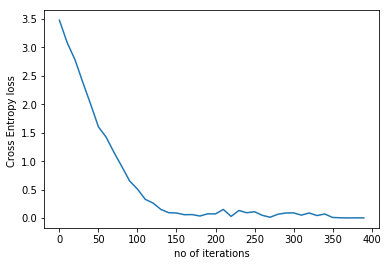

In [30]:
plt.xlabel('no of iterations')
plt.ylabel('Cross Entropy loss ')
plt.savefig('Training_error - predict country - batch norm - no residual - batch statics False .png')

In [ ]:
save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses
        })